In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def show_frame(frame_data: bytes):
    config = frame_config_decode(frame_data[16:16+12])
    frame_bytes = frame_payload_decode(frame_data[16+12:], config)

    depth = np.frombuffer(frame_bytes[0], 'uint16' if 0 == config[1] else 'uint8').reshape(
        240, 320) if frame_bytes[0] else None

    ir = np.frombuffer(frame_bytes[1], 'uint16' if 0 == config[3] else 'uint8').reshape(
        240, 320) if frame_bytes[1] else None

    status = np.frombuffer(frame_bytes[2], 'uint16' if 0 == config[4] else 'uint8').reshape(
        240, 320) if frame_bytes[2] else None

    rgb = np.frombuffer(frame_bytes[3], 'uint8').reshape(
        (480, 640, 3) if config[6] == 1 else (600, 800, 3)) if frame_bytes[3] else None

    figsize = (12, 12)
    fig = plt.figure(figsize=figsize)

    ax1 = fig.add_subplot(221)
    if not depth is None:
        ax1.imshow(depth)
        np.save("fg1.npy", depth)
        # np.savetxt("depth.csv", (depth/4).astype('uint16'), delimiter="," )
    ax2 = fig.add_subplot(222)
    if not ir is None:
        ax2.imshow(ir)
    ax3 = fig.add_subplot(223)
    if not status is None:
        ax3.imshow(status)
    ax4 = fig.add_subplot(224)
    if not rgb is None:
        ax4.imshow(rgb)
        

    return depth,rgb


In [2]:
import struct
import numpy as np
import cv2


def frame_config_decode(frame_config):
    '''
        @frame_config bytes

        @return fields, tuple (trigger_mode, deep_mode, deep_shift, ir_mode, status_mode, status_mask, rgb_mode, rgb_res, expose_time)
    '''
    return struct.unpack("<BBBBBBBBi", frame_config)


def frame_config_encode(trigger_mode=1, deep_mode=1, deep_shift=255, ir_mode=1, status_mode=2, status_mask=7, rgb_mode=1, rgb_res=0, expose_time=0):
    '''
        @trigger_mode, deep_mode, deep_shift, ir_mode, status_mode, status_mask, rgb_mode, rgb_res, expose_time

        @return frame_config bytes
    '''
    return struct.pack("<BBBBBBBBi",
                       trigger_mode, deep_mode, deep_shift, ir_mode, status_mode, status_mask, rgb_mode, rgb_res, expose_time)


def frame_payload_decode(frame_data: bytes, with_config: tuple):
    '''
        @frame_data, bytes

        @with_config, tuple (trigger_mode, deep_mode, deep_shift, ir_mode, status_mode, status_mask, rgb_mode, rgb_res, expose_time)

        @return imgs, tuple (deepth_img, ir_img, status_img, rgb_img)
    '''
    deep_data_size, rgb_data_size = struct.unpack("<ii", frame_data[:8])
    frame_payload = frame_data[8:]
    # 0:16bit 1:8bit, resolution: 320*240
    deepth_size = (320*240*2) >> with_config[1]
    deepth_img = struct.unpack("<%us" % deepth_size, frame_payload[:deepth_size])[
        0] if 0 != deepth_size else None
    frame_payload = frame_payload[deepth_size:]

    # 0:16bit 1:8bit, resolution: 320*240
    ir_size = (320*240*2) >> with_config[3]
    ir_img = struct.unpack("<%us" % ir_size, frame_payload[:ir_size])[
        0] if 0 != ir_size else None
    frame_payload = frame_payload[ir_size:]

    status_size = (320*240//8) * (16 if 0 == with_config[4] else
                                  2 if 1 == with_config[4] else 8 if 2 == with_config[4] else 1)
    status_img = struct.unpack("<%us" % status_size, frame_payload[:status_size])[
        0] if 0 != status_size else None
    frame_payload = frame_payload[status_size:]

    assert(deep_data_size == deepth_size+ir_size+status_size)

    rgb_size = len(frame_payload)
    assert(rgb_data_size == rgb_size)
    rgb_img = struct.unpack("<%us" % rgb_size, frame_payload[:rgb_size])[
        0] if 0 != rgb_size else None

    if (not rgb_img is None):
        if (1 == with_config[6]):
            jpeg = cv2.imdecode(np.frombuffer(
                rgb_img, 'uint8', rgb_size), cv2.IMREAD_COLOR)
            if not jpeg is None:
                rgb = cv2.cvtColor(jpeg, cv2.COLOR_BGR2RGB)
                rgb_img = rgb.tobytes()
            else:
                rgb_img = None
        # elif 0 == with_config[6]:
        #     yuv = np.frombuffer(rgb_img, 'uint8', rgb_size)
        #     print(len(yuv))
        #     if not yuv is None:
        #         rgb = cv2.cvtColor(yuv, cv2.COLOR_YUV420P2RGB)
        #         rgb_img = rgb.tobytes()
        #     else:
        #         rgb_img = None

    return (deepth_img, ir_img, status_img, rgb_img)

In [ ]:
with open("pruebas_fotos/dist_cel.raw", 'rb') as fp:
    file_data = fp.read()
    fp.close()
    depth, rgb = show_frame(file_data)

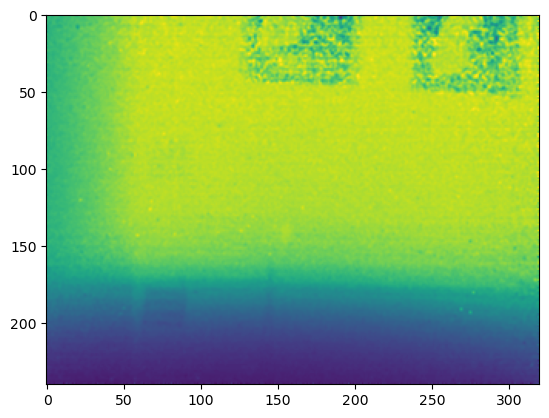

In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load the .npy file
data = np.load("fg1.npy")

# Create a PIL image from the NumPy array
img = Image.fromarray(data)

# Show the image in a window
plt.imshow(img)

In [2]:
import numpy as np
import open3d as o3d

points = o3d.io.read_point_cloud("pruebas_fotos/rgbd_1.pcd")

#points.paint_uniform_color([0.1,0.5,0.2])

o3d.visualization.draw_geometries([points])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: La operación de transformación solicitada no es compatible. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Controlador no válido. 
[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.


In [3]:
points

PointCloud with 68759 points.

In [1]:
import numpy as np
import open3d as o3d

points = o3d.io.read_point_cloud("pruebas_fotos/dist_cel.pcd")

# Estimate the normals
#normals = points.estimate_normals()

distancia = points.compute_nearest_neighbor_distance
    
# Calculate the distance of the nearest point to the object
#nearest_point = points[normals.argmin()]

# Print the distance
#print(nearest_point.distance)
print(distancia)



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
<bound method PyCapsule.compute_nearest_neighbor_distance of PointCloud with 76304 points.>


In [5]:
import requests
import time

HOST = '192.168.233.1'
PORT = 80

def get_frame_from_http(host=HOST, port=PORT):
    r = requests.get('http://{}:{}/getdeep'.format(host, port))
    if(r.status_code == requests.codes.ok):
        print('Get deep image')
        deepimg = r.content
        print('Length={}'.format(len(deepimg)))
        (frameid, stamp_msec) = struct.unpack('<QQ', deepimg[0:8+8])
        print((frameid, stamp_msec/1000))
        return deepimg

# Start the timer
timer = time.time()

# Loop to get new frames from the camera
while True:

    # Get a new frame from the camera
    frame = get_frame_from_http()

    # Display the frame
    # This code will depend on the video player that you are using
    # display_frame(frame)

    # Calculate the time it took to get the frame
    elapsed_time = time.time() - timer

    # Adjust the timer so that the frames are displayed at a constant rate
    timer += 1/30 - elapsed_time

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))